# Clasificación de imágenes utilizando redes neuronales

A continuación aprenderemos a clasificar imágenes de flores utilizando un modelo secuencial de Keras y cargando los datos usando la funcionalidad `tf.keras.utils.image_dataset_from_directory`. Esto mostrará los conceptos de:

- Cargar de manera eficiente un conjunto de datos a partir del disco.
- Identificar el sobreajuste y aplicar técnicas para reducirlo, incluyendo *data augmentation* y *dropout*

Seguiremos el siguiente flujo de trabajo básico del machine learning:

 1. Examinar y entender los datos
 2. Construir una pipeline de entrada
 3. Construir el modelo
 4. Entrenar el modelo
 5. Probar el modelo
 6. Mejorar el modelo y repetir el proceso
 

## Configuración inicial

Necesitamos importar TensorFlow y otras bibliotecas importantes para esta tarea:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import PIL
import tensorflow as tf 
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

## Dataset

En esta ocasión utilizaremos un conjunto de datos que contiene alrededor de 3,700 fotos de flores. El conjunto tiene 5 sub-carpetas, una por cada clase:

    flower_photo/
        daisy/
        dandelion/
        roses/
        sunflowers/
        tulips/

In [2]:
import pathlib

dataset_url = 'https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz'

data_dir = tf.keras.utils.get_file('flower_photos.tar', origin = dataset_url, extract = True)

data_dir = pathlib.Path(data_dir).with_suffix('')

228813984/228813984 [==============================] - 13s 0us/step


Una vez que se ha descargado tenemos una copia del conjunto de datos disponible. Veamos cuántas imágenes contiene en total.

In [3]:
image_count = len(list(data_dir.glob('*/*.jpg')))

print(image_count)

3670


Podemos ver algunos elementos del dataset, por ejemplo rosas:

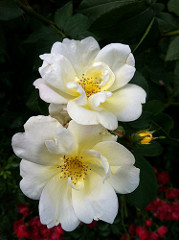

In [4]:
roses = list(data_dir.glob('roses/*'))

PIL.Image.open(str(roses[0]))

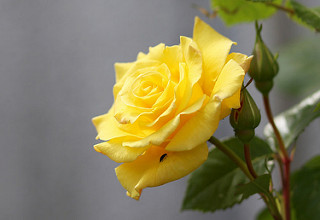

In [5]:
PIL.Image.open(str(roses[42]))

O tal vez algunos tulipanes:

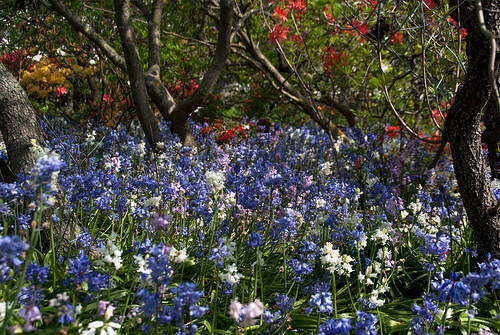

In [7]:
tulips = list(data_dir.glob('tulips/*'))

PIL.Image.open(tulips[1])

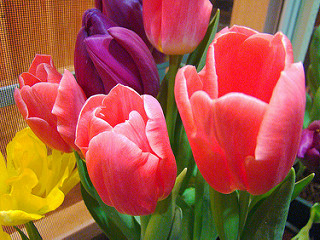

In [8]:
PIL.Image.open(tulips[42])

## Cargando los datos utilizando Keras

Ahora que hemos descargado el conjunto de datos al disco, podemos hacer la carga de las imágenes utilizando la función `tf.keras.utils.image_dataset_from_directory`. Esto va a hacer que las imágenes contenidas en el directorio pasen directament a un `tf.data.Dataset` en unas cuantas líneas de código.


### Creando un dataset

Vamos a definir algunos parámetros para el cargador:

In [9]:
batch_size = 42

img_height = 180

img_width = 180

Es una buena práctica utilizar una segmentación de validación cuando desarrollamos el modelo. Utilizaremos el 80% de las imágenes para el entrenamiento y el 20% restante para la validación.

### Conjunto de entrenamiento

In [10]:
train_ds = tf.keras.utils.image_dataset_from_directory(data_dir,
                                                       validation_split = 0.2,
                                                       subset = 'training',
                                                       seed = 42,
                                                       image_size = (img_height, img_width),
                                                       batch_size = batch_size)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


### Conjunto de validación

In [11]:
val_ds = tf.keras.utils.image_dataset_from_directory(data_dir,
                                                     validation_split = 0.2,
                                                     subset = 'validation',
                                                     seed = 42,
                                                     image_size = (img_height, img_width),
                                                     batch_size = batch_size)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


Podemos encontar los nombres de las clases en el atributo `class_names` de estos conjuntos de datos, y corresponden a los nombres de las carpetas en orden alfabético.

In [12]:
class_names = train_ds.class_names

print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


### Visualizando los datos

Podemos ver las primeras nueve imágenes del conjunto de entrenamiento:

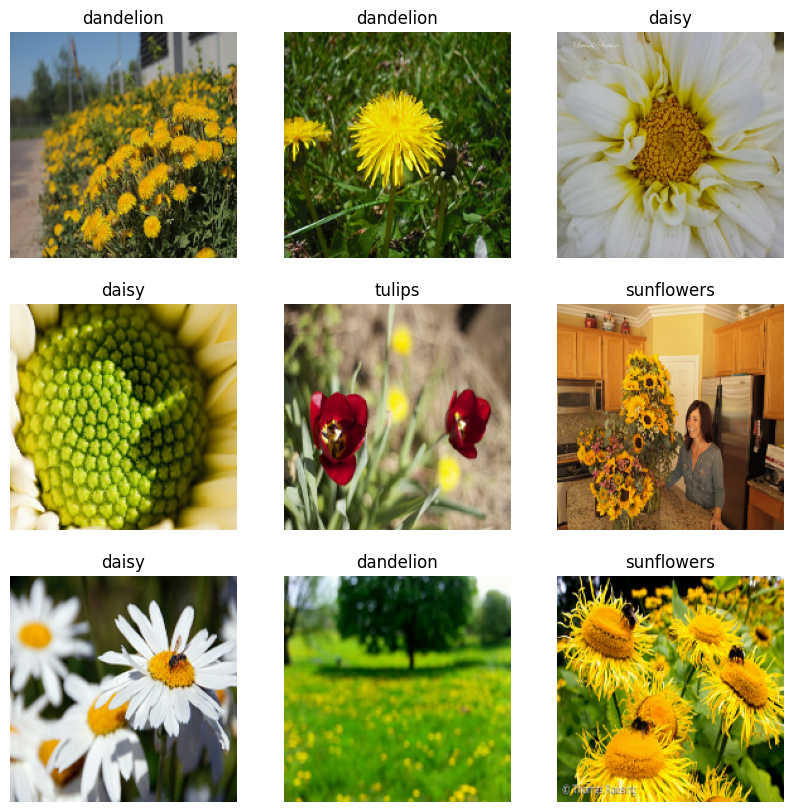

In [13]:
plt.figure(figsize = (10,10))

for images, labels in train_ds.take(1):

    for i in range(9):

        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(class_names[labels[i]])
        plt.axis('off')

Lo que haremos será alimentar con estos conjuntos de datos al método de Keras `Model.fit` para hacer el entrenamiento. 

También, podemos conocer las características de los datos de entrada. Consideremos un lote de ellos:

In [14]:
for image_batch, labels_batch in train_ds:

    print(image_batch.shape)
    print(labels_batch.shape)

    break

(42, 180, 180, 3)
(42,)


Podemos ver que `image_batch` es un tensor de forma `(42, 180, 180, 3)`. Es decir, es un lote que contiene 42 imágenes de tamaño 180 x 180 x 3, donde la última dimensión se refiere a los tres canales de color RGB. Por otro lado, `label_batch` es un tensor de forma `(42,)`, que corresponden a las 42 etiquetas de las imágenes. 

### Configuración del dataset para un mejor rendimiento

Hay dos métodos que pueden utilizarse para tomar datos del disco sin saturar los recursos del computador:

- `Dataset.cache` mantiene a las imágenes en la memoria después de cargarlas desde el disco durante la primera época. Esto asegurará que el conjunto de datos no se convierta en un cuello de botella mientras entrenamos el modelo. Si el conjunto de datos es demasiado largo para caber en la memoria, también se puede utilizar este método para crear una caché en disco de alto rendimiento.

- `Datase.prefetch` este método sobrepone el pre procesamiento de datos y la ejecución del modelo durante el entrenamiento.

En esta ocasión utilizaremos el primer método.


In [15]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = AUTOTUNE)

val_ds = val_ds.cache().prefetch(buffer_size = AUTOTUNE)

### Normalización de los datos

Los valores del canal RGB están en el rango de `[0, 255]`. Esto no es ideal para una red neuronal, en general debemos buscar que los valores de entrada sean pequeños (de preferencia entre 0 y $\pm$ 1). 

Vamos a normalizar los datos para que estén en `[0, 1]` con la funcionalidad `tf.keras.layers.Rescaling`:

In [16]:
normalization_layer = layers.Rescaling(1./255)

Hay dos formas de utilizar esta capa. Podemos aplicarla al conjunto de datos al utilizar la función `Dataset.map`

In [17]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))

image_batch, labels_batch = next(iter(normalized_ds))

first_image = image_batch[0]

# Notemos que los valores de los pixeles ahora están en el rango [0,1]

print(np.min(first_image), np.max(first_image))

0.0 1.0


### Creación del modelo

Vamos a generar una red neuronal convolucional secuencial. La arquitectura va a consistir en tres capas de convolución (`tf.keras.layers.Conv2D`) con una capa de max pooling en cada una de ellas (`tf.keras.layers.MaxPooling2D`). También con una capa completamente conectada (`tf.keras.layers.Dense`) con 128 unidades y con función de activación ReLU (`relu`).

In [18]:
num_classes = len(class_names)

model = Sequential([
    layers.Rescaling(1./255, input_shape = (img_height, img_width, 3)),
    layers.Conv2D(16, 3, padding = 'same', activation = 'relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding = 'same', activation = 'relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding = 'same', activation = 'relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation = 'relu'),
    layers.Dense(num_classes)
])

### Compilación del modelo

En esta ocasión, utilizaremos el optimizador ADAM (`tf.keras.optimizers.Adam`) y la función de costo Sparse Categorical Cross Entropy (`tf.keras.losses.SparseCategorialCrossentropy`). Para ver la precisión del entrenamiento y la validación para cada época de entramiento pasamos el argumento `metrics`a `Model.compile`.

In [19]:
model.compile(optimizer = 'adam',
              loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
              metrics = ['accuracy'])

### Resumen del modelo

Para ver todas las capas de la red utilizamos el método `Model.summary`

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

### Entrenamiento del modelo

Vamos a entrenar el modelo durante 25 épocas con el método `Model.fit`

In [21]:
epochs = 25

history = model.fit(train_ds, validation_data = val_ds, epochs = epochs)

Epoch 1/25
70/70 [==============================] - 30s 422ms/step - loss: 1.4589 - accuracy: 0.3733 - val_loss: 1.1153 - val_accuracy: 0.4918
Epoch 2/25
70/70 [==============================] - 29s 421ms/step - loss: 1.0837 - accuracy: 0.5402 - val_loss: 1.0577 - val_accuracy: 0.5858
Epoch 3/25
70/70 [==============================] - 30s 426ms/step - loss: 0.9132 - accuracy: 0.6448 - val_loss: 0.9684 - val_accuracy: 0.6226
Epoch 4/25
70/70 [==============================] - 29s 419ms/step - loss: 0.7302 - accuracy: 0.7187 - val_loss: 1.0481 - val_accuracy: 0.6104
Epoch 5/25
70/70 [==============================] - 28s 400ms/step - loss: 0.5610 - accuracy: 0.7967 - val_loss: 0.9875 - val_accuracy: 0.6512
Epoch 6/25
70/70 [==============================] - 28s 395ms/step - loss: 0.3878 - accuracy: 0.8621 - val_loss: 1.0826 - val_accuracy: 0.6335
Epoch 7/25
70/70 [==============================] - 28s 397ms/step - loss: 0.2427 - accuracy: 0.9217 - val_loss: 1.1677 - val_accuracy: 0.6526

### Visualizando los resultados del entrenamiento

Podemos generar gráficas para el valor de la función de costo y de la precisión de los conjuntos de entrenamiento y validación:

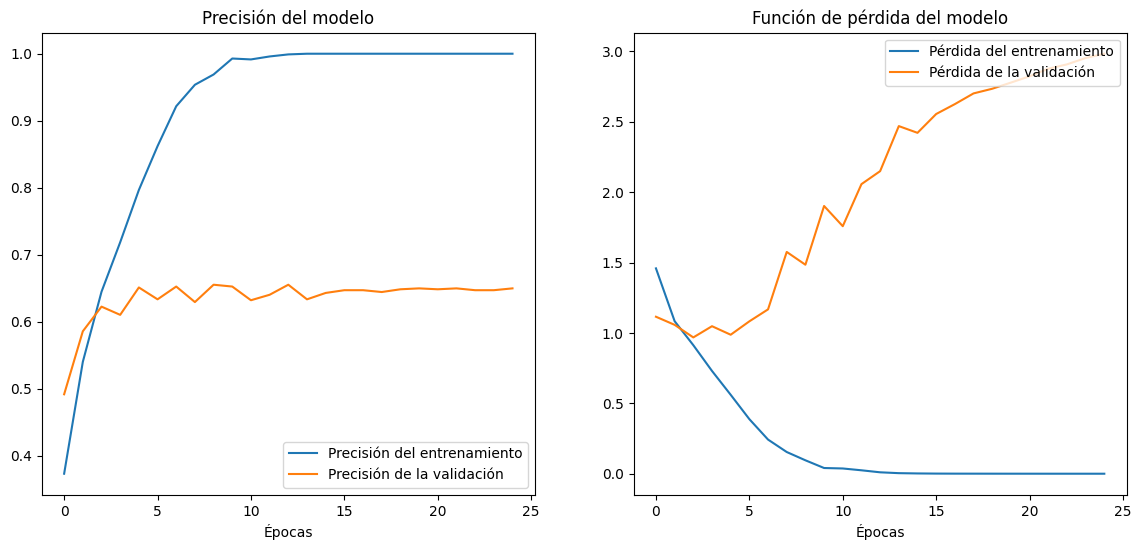

In [26]:
loss = history.history['loss']

val_loss = history.history['val_loss']

acc = history.history['accuracy']

val_acc = history.history['val_accuracy']

epochs_range = range(epochs)

plt.figure(figsize = (14,6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label = 'Precisión del entrenamiento')
plt.plot(epochs_range, val_acc, label = 'Precisión de la validación')
plt.xlabel('Épocas')
plt.legend(loc = 'lower right')
plt.title('Precisión del modelo')

plt.subplot(1,2,2)
plt.plot(epochs_range, loss, label = 'Pérdida del entrenamiento')
plt.plot(epochs_range, val_loss, label = 'Pérdida de la validación')
plt.xlabel('Épocas')
plt.legend(loc = 'upper right')
plt.title('Función de pérdida del modelo')

plt.show()

Notemos que las gráficas muestran que la precisión del entrenamiento y la precisión de la validación están muy alejadas, además de que el modelo sólo ha alcanzado sólo alrededor del 60% de precisión sobre el conjunto de validación.

Esto no es lo ideal, necesitamos mejorar los resultados, así que vamos a inspeccionar qué pudo haber salido mal y vamos a tratar de incrementar el desempeño general del modelo.

### Sobreajuste

En las gráficas anteriores, la precisión del entrenamiento incrementa casi de forma lineal con el tiempo, mientras que la precisión de la validación se estanca alrededor del 60% durante el entrenamiento. También, como ya dijimos, la diferencia entre la precisión del entrenamiento y la validación es evidente, esto representa una señal de *sobreajuste*. 

Cuando tenemos un número pequeño de ejemplos de entrenamiento, el modelo a veces tiende a aprender de ruido o detalles no requeridos de los ejemplos, hasta el punto de afectar negativamente el desempeño del modelo sobre nuevos ejemplos. Este fenómeno es conocido como sobreajuste y significa que al modelo se le complica generalizar sobre un nuevo conjunto de datos.

Existen diversas formas de evitar el sobreajuste durante el proceso de entrenamiento, en este caso utilizaremos *data augmentation* y añadiremos una capa de *dropout* al modelo.

### Data augmentation

La técnica de data augmentation ayuda a combatir el sobreajuste cuando tenemos un conjunto pequeño de datos, ya que genera datos de entrenamiento adicionales a partir de los ejemplos existentes al aumentarlos utilizando transformaciones aleatorias que generan imágenes similares. Esta ayuda expone al modelo a más aspectos de los datos y a generalizar mejor.

Afortunadamente, podemos implementar data augmentation al utilizar las capas de pre procesamiento de Keras: `tf.keras.layers.RandomFlip`, `tf.keras.layers.RandomRotation` y `tf.keras.layers.RandomZoom`.

In [27]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip('horizontal', input_shape = (img_height, img_width, 3)),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.1),
    ]
)

Veamos cómo se ven estos ejemplos aumentados, le vamos a aplicar data augmentation a la misma imagen varias veces:

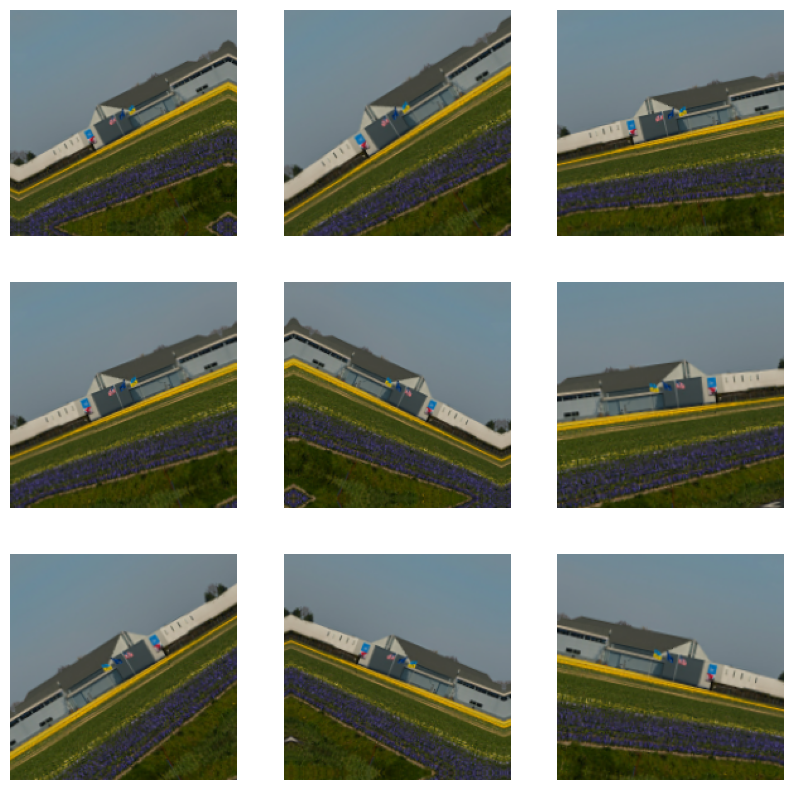

In [28]:
plt.figure(figsize = (10, 10))

for images, _ in train_ds.take(1):

    for i in range(9):

        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype('uint8'))
        plt.axis('off')

### Dropout

Otra técnica utilizada para reducir el sobreajuste es introducir una regularización dropout a la red neuronal. Cuando aplicamos dropout a una capa, elimina aleatoriamente cierto número de unidades de salida de la capa durante el proceso de entrenamiento (al hacer que la activación sea cero). El dropout toma un número fraccionario como su valor de entrada, de la forma 0.1, 0.2, 0.5, etc. Esto significa que elimina el 10%, 20$ o 50% de las neuronas de salida de manera aleatoria de la capa aplicada.

Vamos a crear una nueva red neuronal con `tf.keras.layers.Dropout` antes de entrenarla utilizando las imágenes aumentadas.

In [30]:
model_2 = Sequential([
    data_augmentation,
    layers.Rescaling(1./255),
    layers.Conv2D(16, 3, padding = 'same', activation = 'relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding = 'same', activation = 'relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding = 'same', activation = 'relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(128, activation = 'relu'),
    layers.Dense(num_classes, name = 'outputs')
])

### Compilación y entrenamiento

In [31]:
model_2.compile(optimizer = 'adam',
                loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics = ['accuracy'])

In [32]:
model_2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_3 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                  

In [33]:
history_2 = model_2.fit(train_ds, validation_data = val_ds, epochs = epochs)

Epoch 1/25
70/70 [==============================] - 35s 457ms/step - loss: 1.2408 - accuracy: 0.4802 - val_loss: 1.1342 - val_accuracy: 0.5804
Epoch 2/25
70/70 [==============================] - 33s 466ms/step - loss: 1.0205 - accuracy: 0.6029 - val_loss: 0.9633 - val_accuracy: 0.6063
Epoch 3/25
70/70 [==============================] - 35s 497ms/step - loss: 0.8995 - accuracy: 0.6413 - val_loss: 0.8730 - val_accuracy: 0.6608
Epoch 4/25
70/70 [==============================] - 36s 517ms/step - loss: 0.8084 - accuracy: 0.6809 - val_loss: 0.8490 - val_accuracy: 0.6730
Epoch 5/25
70/70 [==============================] - 36s 520ms/step - loss: 0.7743 - accuracy: 0.6982 - val_loss: 0.9119 - val_accuracy: 0.6717
Epoch 6/25
70/70 [==============================] - 37s 522ms/step - loss: 0.7233 - accuracy: 0.7200 - val_loss: 0.8426 - val_accuracy: 0.6935
Epoch 7/25
70/70 [==============================] - 36s 516ms/step - loss: 0.6764 - accuracy: 0.7391 - val_loss: 0.8096 - val_accuracy: 0.7071

### Resultados del entrenamiento

Después de aplicar el aumento de datos y el dropout, vamos a ver si tenemos menos sobreajuste que antes, deberíamos ver que la precisión del entrenamiento y la validación sean más cercanas.

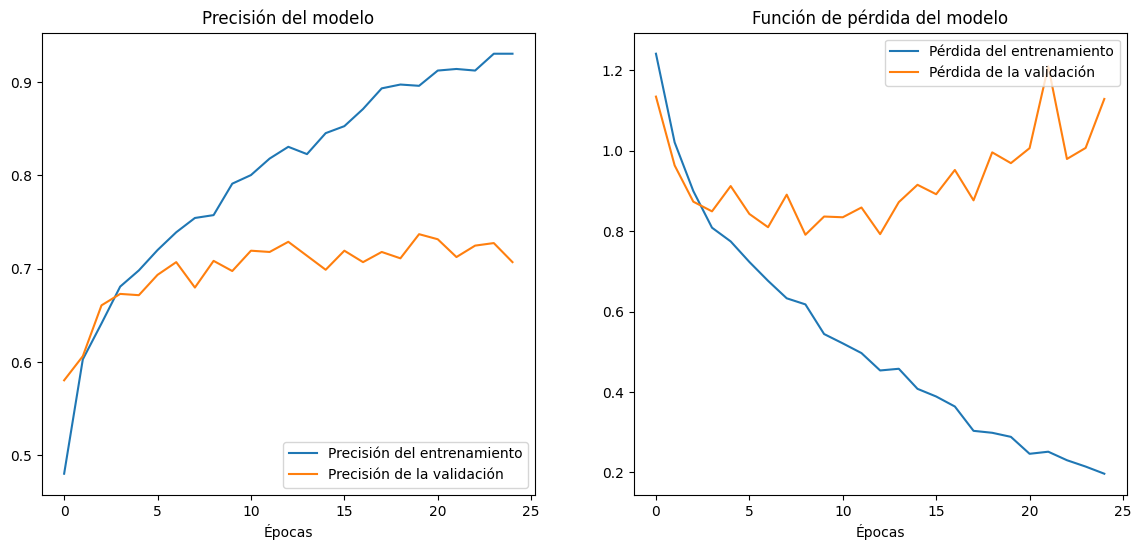

In [35]:
acc_2 = history_2.history['accuracy']

val_acc_2 = history_2.history['val_accuracy']

loss_2 = history_2.history['loss']

val_loss_2 = history_2.history['val_loss']

plt.figure(figsize = (14, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc_2, label = 'Precisión del entrenamiento')
plt.plot(epochs_range, val_acc_2, label = 'Precisión de la validación')
plt.xlabel('Épocas')
plt.legend(loc = 'lower right')
plt.title('Precisión del modelo')

plt.subplot(1,2,2)
plt.plot(epochs_range, loss_2, label = 'Pérdida del entrenamiento')
plt.plot(epochs_range, val_loss_2, label = 'Pérdida de la validación')
plt.xlabel('Épocas')
plt.legend(loc = 'upper right')
plt.title('Función de pérdida del modelo')

plt.show()

### Predicción en nuevos datos

Finalmente, podemos utilizar el modelo para clasificar imágenes que nunca antes ha visto.

In [36]:
sunflower_url = 'https://storage.googleapis.com/download.tensorflow.org/example_images/592px-Red_sunflower.jpg'

sunflower_path = tf.keras.utils.get_file('Red_sunflower', origin=sunflower_url)

img = tf.keras.utils.load_img(
    sunflower_path, target_size = (img_height, img_width)
)

img_array = tf.keras.utils.img_to_array(img)

img_array = tf.expand_dims(img_array, 0) # Creamos un lote

predictions = model_2.predict(img_array)

score = tf.nn.softmax(predictions[0])

print('This image most likely belongs to {} with a {:.2f} percent of confidence.'.format(class_names[np.argmax(score)], 100 * np.max(score)))

1/1 [==============================] - 0s 120ms/step
This image most likely belongs to sunflowers with a 100.00 percent of confidence.
